In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVBeam
import healpy as hp
from scipy.signal import deconvolve
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import wiener

## Widening the Beam

In [6]:
def hera_beam_freq_slice(hera_beam, freq, beam_center = 90, ang_from_center = 15, n = 100):
    '''
    Returns a beam cut at a defined frequency
    
    Parameters
    ----------
    hera_beam : UVBeam
        HERA beam model simulation read into a UVBeam object
    freq: int
        Frequency to pull from simulation
    beam_center: float, optional
        Zenith declination, set to 90 degrees in the simulation
    ang_from_center: int
        Angle from zenith to map the simulated beam out to
    n: int
        Number of points in the plot 
    
    Returns
    -------
    ang : array-like
        Angle from zenith for each point in the beam model
    beam_slice: array-like
        Beam model at the given frequency and angle range
    
    '''
    ang = np.linspace(beam_center-ang_from_center,beam_center+ang_from_center,n)
    beam_slice     = []
    beam_map       = hera_beam[:,freq-50]
    beam_map_norm  = beam_map/np.max(beam_map) 

    for i in ang:
        beam_slice.append(hp.get_interp_val(beam_map_norm, 0, i, lonlat=True))  
    
    return ang, np.array(beam_slice)

In [7]:
hera_beam_file = '/Users/tyler/Desktop/Research/Tsys/data/HERA_beam_nic.hmap'
hera_im = fits.getdata(hera_beam_file, extname='BEAM_{0}'.format('X'))
nside = hp.npix2nside(hera_im.shape[0])
temp_f = fits.getdata(hera_beam_file, extname='FREQS_{0}'.format('X'))

In [8]:
ang, beam = hera_beam_freq_slice(hera_im, 100, ang_from_center=90, n=300)

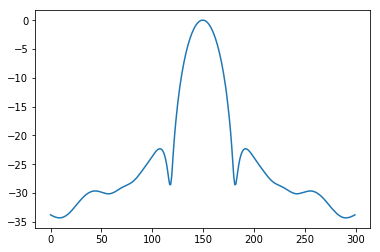

In [9]:
plt.plot(10*np.log10(beam))

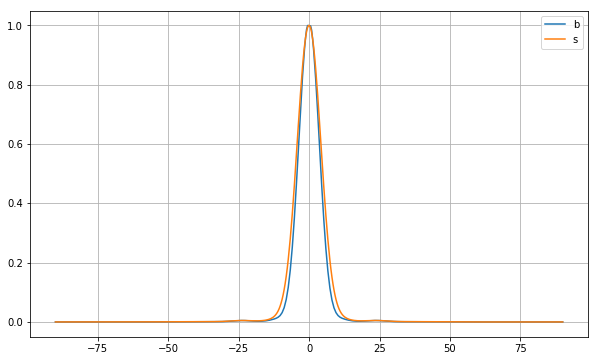

In [12]:
std = 2.5
std1 = 1
ang, beam = hera_beam_freq_slice(hera_im, 200, ang_from_center=90, n=500)

np.random.seed(1)
deg = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std)))
deg2 = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std1)))

smooth = gaussian_filter(beam, deg)
squigg = smooth+smooth*np.random.uniform(-0.2, 0.2, smooth.shape[0])
smooth_squigg = gaussian_filter(squigg, deg2)

w_noise = beam+gaussian_filter(beam*np.random.uniform(-0.25, 0.25, beam.shape[0]), deg2)

plt.figure(figsize=(10,6))
plt.plot(ang-90, beam, label='b')
#plt.plot(ang-90, conv_beam, label='c')
plt.plot(ang-90, smooth/smooth.max(), label='s')
#plt.plot(ang-90, 10.0**(smooth/10.0), label='s')
plt.legend()
plt.grid()
plt.show()

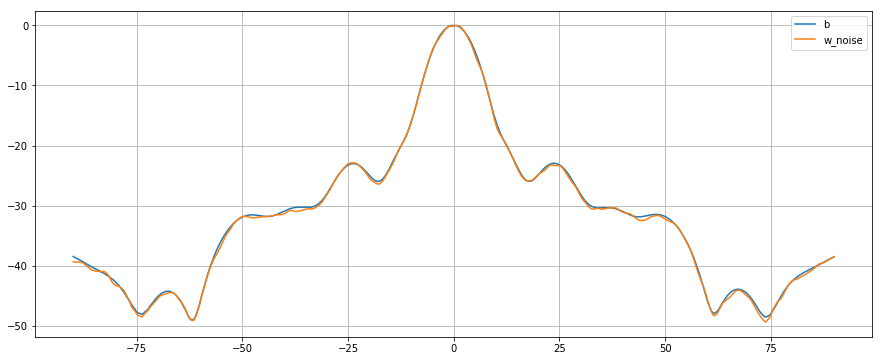

In [13]:
plt.figure(figsize=(15,6))
plt.plot(ang-90, 10*np.log10(beam), label='b')
plt.plot(ang-90, 10*np.log10(w_noise/w_noise.max()), label='w_noise')
plt.legend()

plt.grid()
plt.show()

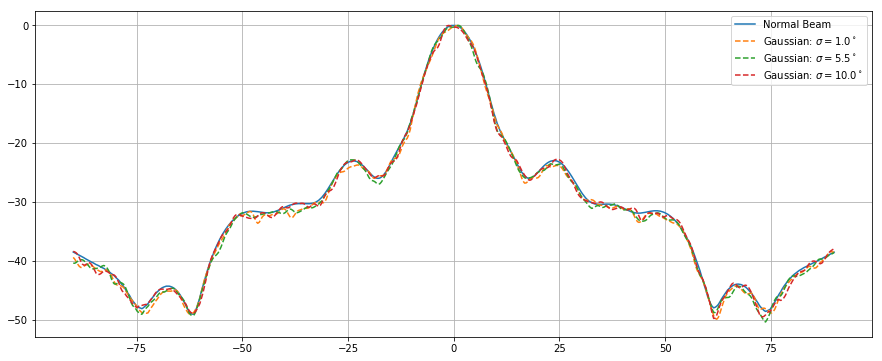

In [14]:
ang, beam = hera_beam_freq_slice(hera_im, 200, ang_from_center=90, n=500)
np.random.seed(1)

plt.figure(figsize=(15,6))

plt.plot(ang-90, 10*np.log10(beam), label='Normal Beam')

for std in np.linspace(1, 10, 3):
    deg2 = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std1)))
    smooth = beam+gaussian_filter(beam*np.random.uniform(-0.5, 0.5, beam.shape[0]), deg2)
    plt.plot(ang-90, 10*np.log10(smooth/smooth.max()), linestyle='--',label='Gaussian: $\sigma = ${}$^\circ$'.format(std))
plt.legend()
plt.grid()
plt.show()

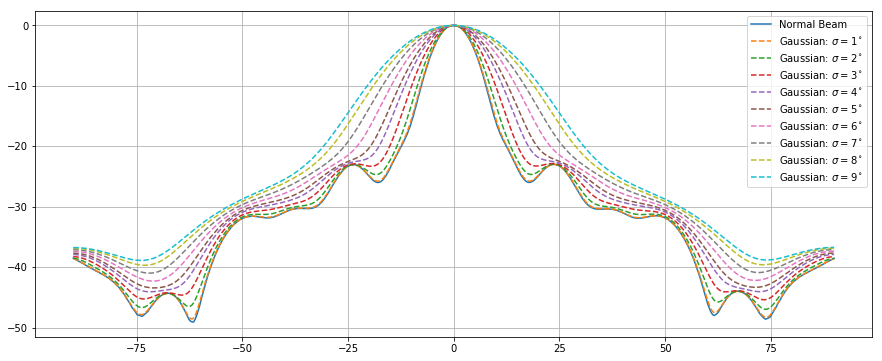

In [15]:
ang, beam = hera_beam_freq_slice(hera_im, 200, ang_from_center=90, n=500)
np.random.seed(1)

plt.figure(figsize=(15,6))

plt.plot(ang-90, 10*np.log10(beam), label='Normal Beam')

for std in np.arange(1,10):
    deg = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std)))
    smooth = gaussian_filter(beam, deg)
    plt.plot(ang-90, 10*np.log10(smooth / smooth.max()), linestyle='--',label='Gaussian: $\sigma = ${}$^\circ$'.format(std))
plt.legend()
plt.grid()
plt.show()

Sigma is 305.755848 arcmin (0.088941 rad) 
-> fwhm is 720.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


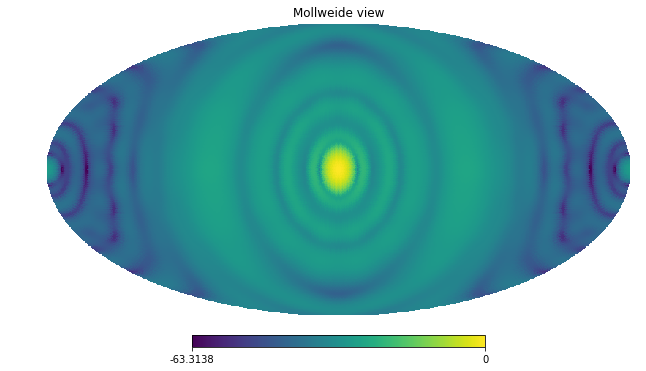

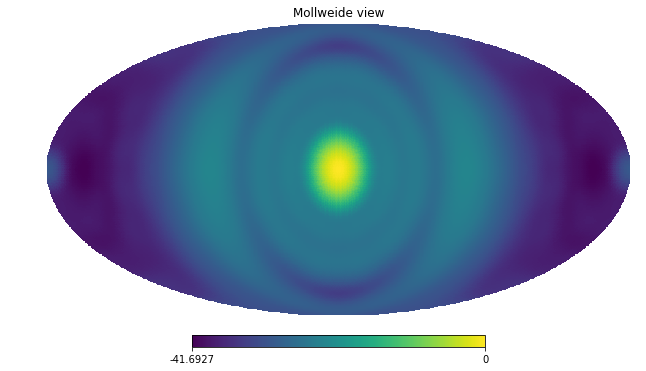

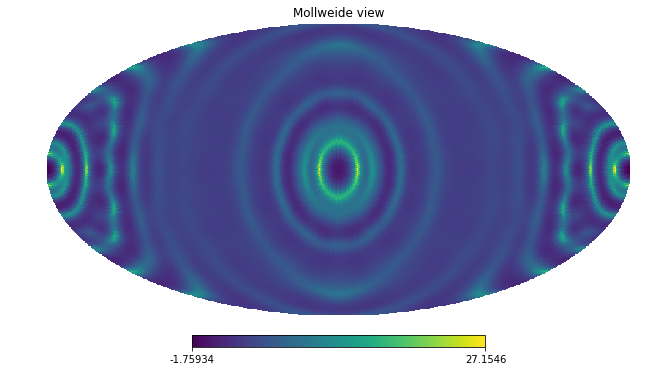

In [16]:
deg = 5
rad_to_deg = np.pi / 180.0
sig_to_fwhm = 2.4

smoothed_beam = hp.sphtfunc.smoothing(hera_im[:,100], fwhm=deg*rad_to_deg*sig_to_fwhm)
hp.mollview(10*np.log10(hera_im[:,100]), rot=[0,90])
hp.mollview(10*np.log10(smoothed_beam/smoothed_beam.max()), rot=[0,90])
hp.mollview(10*np.log10(smoothed_beam/smoothed_beam.max())-10*np.log10(hera_im[:,100]), rot=[0,90])

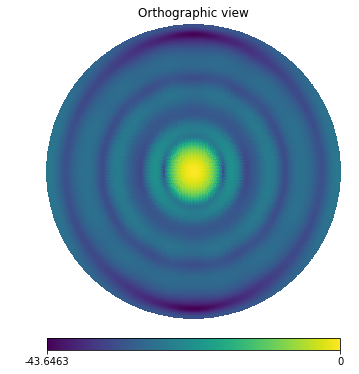

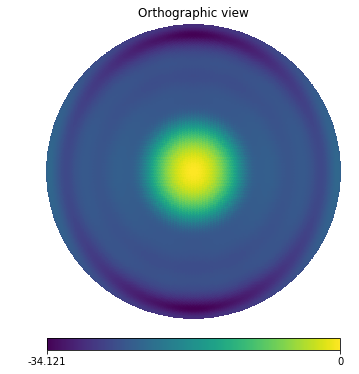

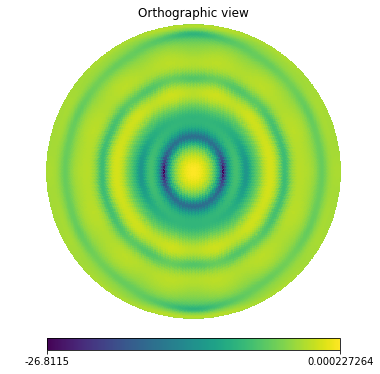

In [17]:
hp.orthview(10*np.log10(hera_im[:,100]), rot=[0,90], return_projected_map=False, half_sky=True)
hp.orthview(10*np.log10(smoothed_beam/smoothed_beam.max()), rot=[0,90], return_projected_map=False, half_sky=True)
diff_beam = hp.orthview(10*np.log10(hera_im[:,100])-10*np.log10(smoothed_beam/smoothed_beam.max()), rot=[0,90], return_projected_map=True, half_sky=True)

## Narrowing the Beam

In [18]:
def beam_cut(hera_beam, beam_center = 90, ang_from_center = 15, n = 100):
    ang = np.linspace(beam_center-ang_from_center,beam_center+ang_from_center,n)
    beam_slice     = [] 
    
    for i in ang:
        beam_slice.append(hp.get_interp_val(hera_beam, 0, i, lonlat=True))
    return np.array(ang), np.array(beam_slice)

5.117056856187304


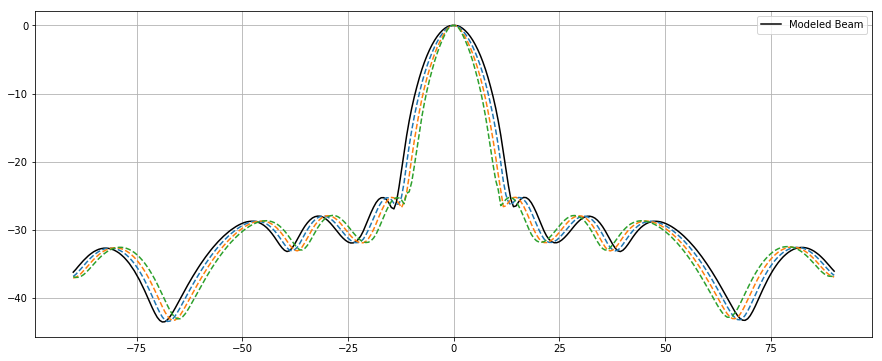

In [50]:
ang, beam = beam_cut(hera_im[:,100], ang_from_center=90, n=300)

fwhm = []

idx = np.argmin(np.abs(beam - np.max(beam) / 2.0))
print np.abs(ang[idx] - 90)


fwhm.append(2*np.abs(ang[idx] - 90))

plt.figure(figsize=(15,6))
#plt.plot(ang-90,beam, 'k', label='Modeled Beam')
plt.plot(ang-90, 10*np.log10(beam), 'k', label='Modeled Beam')

for j in [2,4,6]:
    scale = np.zeros_like(hera_im[:,100])
    s = j*0.01
    for i in np.arange(int(hera_im[:,100].shape[0]/ 1.8)):
        theta, phi = hp.pix2ang(nside, i)
        scale[i] = hp.get_interp_val(hera_im[:,100], theta+s,  phi+s)
    ang, beam_scale = beam_cut(scale, ang_from_center=90, n=300)
    idx_1 = np.argmin(np.abs((ang-90) - np.abs(ang[np.r_[True, beam_scale[1:] < beam_scale[:-1]] & 
                                               np.r_[beam_scale[:-1] < beam_scale[1:], True]]-90).min()))
    idx_2 = np.argmin(np.abs((ang-90) + np.abs(ang[np.r_[True, beam_scale[1:] < beam_scale[:-1]] & 
                                                   np.r_[beam_scale[:-1] < beam_scale[1:], True]]-90).min()))
    ratio = beam.max() / beam_scale.max()
    beam_scale[idx_2:idx_1] *= ratio
    idx = np.argmin(np.abs(beam_scale - np.max(beam_scale) / 2.0))
    fwhm.append(2*np.abs(ang[idx] - 90))
    #plt.plot(ang-90, beam_scale, linestyle='--')
    plt.plot(ang-90, 10*np.log10(beam_scale), linestyle='--')
plt.legend()
plt.grid()
plt.show()



In [51]:
(np.array(fwhm).max()-np.array(fwhm))/np.array(fwhm).max()

array([0.        , 0.11764706, 0.23529412, 0.35294118])

# Widening the Beam

5.313283208020053
0.012757845597670932 0.7853981633974483
0.012757845597670932 2.356194490192345
0.012757845597670932 3.9269908169872414
0.012757845597670932 5.497787143782138
0.02551621035741883 0.39269908169872414
0.02551621035741883 1.1780972450961724
0.02551621035741883 1.9634954084936207
0.02551621035741883 2.748893571891069
0.02551621035741883 3.5342917352885173
0.02551621035741883 4.319689898685965
0.02551621035741883 5.105088062083414
0.02551621035741883 5.890486225480862
0.038275613631490575 0.2617993877991494
0.038275613631490575 0.7853981633974483
0.038275613631490575 1.3089969389957472
0.038275613631490575 1.832595714594046
0.038275613631490575 2.356194490192345
0.038275613631490575 2.8797932657906435
0.038275613631490575 3.4033920413889427
0.038275613631490575 3.926990816987241
0.038275613631490575 4.4505895925855405
0.038275613631490575 4.974188368183839
0.038275613631490575 5.497787143782138
0.038275613631490575 6.021385919380436
0.05103657515266638 0.19634954084936207
0

0.1404507626461692 2.498994156264608
0.1404507626461692 2.6417938223368718
0.1404507626461692 2.7845934884091346
0.1404507626461692 2.927393154481398
0.1404507626461692 3.0701928205536615
0.1404507626461692 3.2129924866259247
0.1404507626461692 3.3557921526981884
0.1404507626461692 3.4985918187704512
0.1404507626461692 3.6413914848427145
0.1404507626461692 3.784191150914978
0.1404507626461692 3.926990816987242
0.1404507626461692 4.069790483059505
0.1404507626461692 4.212590149131768
0.1404507626461692 4.355389815204031
0.1404507626461692 4.498189481276295
0.1404507626461692 4.640989147348558
0.1404507626461692 4.783788813420821
0.1404507626461692 4.926588479493085
0.1404507626461692 5.069388145565348
0.1404507626461692 5.2121878116376115
0.1404507626461692 5.354987477709875
0.1404507626461692 5.497787143782138
0.1404507626461692 5.640586809854401
0.1404507626461692 5.783386475926664
0.1404507626461692 5.926186141998929
0.1404507626461692 6.068985808071191
0.1404507626461692 6.211785474

0.2173092378289772 3.5573916812707953
0.2173092378289772 3.649791465199907
0.2173092378289772 3.742191249129018
0.2173092378289772 3.83459103305813
0.2173092378289772 3.9269908169872414
0.2173092378289772 4.019390600916353
0.2173092378289772 4.111790384845465
0.2173092378289772 4.204190168774576
0.2173092378289772 4.2965899527036875
0.2173092378289772 4.3889897366328
0.2173092378289772 4.481389520561911
0.2173092378289772 4.573789304491022
0.2173092378289772 4.666189088420134
0.2173092378289772 4.758588872349245
0.2173092378289772 4.850988656278357
0.2173092378289772 4.943388440207468
0.2173092378289772 5.03578822413658
0.2173092378289772 5.128188008065692
0.2173092378289772 5.220587791994803
0.2173092378289772 5.312987575923915
0.2173092378289772 5.405387359853027
0.2173092378289772 5.497787143782138
0.2173092378289772 5.59018692771125
0.2173092378289772 5.682586711640361
0.2173092378289772 5.774986495569472
0.2173092378289772 5.867386279498584
0.2173092378289772 5.959786063427695
0.2

0.28160021642986005 1.249497078132304
0.28160021642986005 1.3208969111684359
0.28160021642986005 1.3922967442045673
0.28160021642986005 1.463696577240699
0.28160021642986005 1.5350964102768307
0.28160021642986005 1.6064962433129624
0.28160021642986005 1.6778960763490942
0.28160021642986005 1.7492959093852256
0.28160021642986005 1.8206957424213572
0.28160021642986005 1.892095575457489
0.28160021642986005 1.963495408493621
0.28160021642986005 2.0348952415297523
0.28160021642986005 2.106295074565884
0.28160021642986005 2.1776949076020156
0.28160021642986005 2.2490947406381476
0.28160021642986005 2.320494573674279
0.28160021642986005 2.3918944067104104
0.28160021642986005 2.4632942397465425
0.28160021642986005 2.534694072782674
0.28160021642986005 2.6060939058188057
0.28160021642986005 2.6774937388549374
0.28160021642986005 2.748893571891069
0.28160021642986005 2.8202934049272006
0.28160021642986005 2.891693237963332
0.28160021642986005 2.9630930709994643
0.28160021642986005 3.034492904035

0.3073950510845034 5.465062220307245
0.3073950510845034 5.530512067257032
0.3073950510845034 5.595961914206819
0.3073950510845034 5.661411761156606
0.3073950510845034 5.726861608106393
0.3073950510845034 5.792311455056182
0.3073950510845034 5.857761302005969
0.3073950510845034 5.9232111489557555
0.3073950510845034 5.988660995905543
0.3073950510845034 6.05411084285533
0.3073950510845034 6.119560689805119
0.3073950510845034 6.1850105367549055
0.3073950510845034 6.250460383704692
0.3203115468633599 0.031415926535897934
0.3203115468633599 0.09424777960769379
0.3203115468633599 0.15707963267948966
0.3203115468633599 0.21991148575128552
0.3203115468633599 0.2827433388230814
0.3203115468633599 0.34557519189487723
0.3203115468633599 0.4084070449666731
0.3203115468633599 0.4712388980384689
0.3203115468633599 0.5340707511102649
0.3203115468633599 0.5969026041820606
0.3203115468633599 0.6597344572538566
0.3203115468633599 0.7225663103256523
0.3203115468633599 0.7853981633974483
0.3203115468633599

0.3461855917034184 3.9269908169872414
0.3461855917034184 3.985168458720386
0.3461855917034184 4.04334610045353
0.3461855917034184 4.101523742186674
0.3461855917034184 4.159701383919819
0.3461855917034184 4.217879025652963
0.3461855917034184 4.276056667386108
0.3461855917034184 4.3342343091192514
0.3461855917034184 4.392411950852396
0.3461855917034184 4.4505895925855405
0.3461855917034184 4.508767234318684
0.3461855917034184 4.566944876051829
0.3461855917034184 4.625122517784973
0.3461855917034184 4.683300159518118
0.3461855917034184 4.7414778012512615
0.3461855917034184 4.799655442984406
0.3461855917034184 4.857833084717551
0.3461855917034184 4.916010726450695
0.3461855917034184 4.974188368183839
0.3461855917034184 5.032366009916983
0.3461855917034184 5.090543651650127
0.3461855917034184 5.1487212933832724
0.3461855917034184 5.206898935116417
0.3461855917034184 5.265076576849561
0.3461855917034184 5.323254218582705
0.3461855917034184 5.381431860315849
0.3461855917034184 5.4396095020489

0.3721182990407883 6.039441049573481
0.3721182990407883 6.093606440152616
0.3721182990407883 6.14777183073175
0.3721182990407883 6.201937221310884
0.3721182990407883 6.25610261189002
0.3851081447625733 0.02617993877991494
0.3851081447625733 0.07853981633974483
0.3851081447625733 0.1308996938995747
0.3851081447625733 0.1832595714594046
0.3851081447625733 0.23561944901923448
0.3851081447625733 0.28797932657906433
0.3851081447625733 0.3403392041388943
0.3851081447625733 0.3926990816987241
0.3851081447625733 0.44505895925855404
0.3851081447625733 0.4974188368183839
0.3851081447625733 0.5497787143782138
0.3851081447625733 0.6021385919380436
0.3851081447625733 0.6544984694978736
0.3851081447625733 0.7068583470577035
0.3851081447625733 0.7592182246175334
0.3851081447625733 0.8115781021773631
0.3851081447625733 0.8639379797371931
0.3851081447625733 0.916297857297023
0.3851081447625733 0.9686577348568529
0.3851081447625733 1.0210176124166828
0.3851081447625733 1.0733774899765125
0.3851081447625

0.3981144608553928 4.940407802016207
0.3981144608553928 4.991078651267655
0.3981144608553928 5.041749500519104
0.3981144608553928 5.092420349770552
0.3981144608553928 5.143091199022
0.3981144608553928 5.193762048273448
0.3981144608553928 5.244432897524896
0.3981144608553928 5.295103746776345
0.3981144608553928 5.345774596027793
0.3981144608553928 5.396445445279242
0.3981144608553928 5.44711629453069
0.3981144608553928 5.497787143782138
0.3981144608553928 5.548457993033587
0.3981144608553928 5.599128842285035
0.3981144608553928 5.649799691536483
0.3981144608553928 5.700470540787931
0.3981144608553928 5.751141390039379
0.3981144608553928 5.801812239290827
0.3981144608553928 5.852483088542276
0.3981144608553928 5.903153937793724
0.3981144608553928 5.953824787045172
0.3981144608553928 6.00449563629662
0.3981144608553928 6.055166485548068
0.3981144608553928 6.105837334799518
0.3981144608553928 6.156508184050966
0.3981144608553928 6.207179033302414
0.3981144608553928 6.257849882553862
0.4111

0.4241789711207841 3.7365912622242234
0.4241789711207841 3.784191150914978
0.4241789711207841 3.8317910396057324
0.4241789711207841 3.8793909282964867
0.4241789711207841 3.926990816987241
0.4241789711207841 3.974590705677996
0.4241789711207841 4.022190594368751
0.4241789711207841 4.069790483059505
0.4241789711207841 4.117390371750259
0.4241789711207841 4.164990260441013
0.4241789711207841 4.212590149131769
0.4241789711207841 4.260190037822523
0.4241789711207841 4.307789926513277
0.4241789711207841 4.355389815204031
0.4241789711207841 4.402989703894786
0.4241789711207841 4.4505895925855405
0.4241789711207841 4.498189481276295
0.4241789711207841 4.545789369967049
0.4241789711207841 4.593389258657804
0.4241789711207841 4.640989147348558
0.4241789711207841 4.688589036039312
0.4241789711207841 4.736188924730067
0.4241789711207841 4.783788813420822
0.4241789711207841 4.831388702111576
0.4241789711207841 4.87898859080233
0.4241789711207841 4.926588479493084
0.4241789711207841 4.97418836818384

0.4503168351444855 2.849873335756455
0.4503168351444855 2.894753230807738
0.4503168351444855 2.9396331258590207
0.4503168351444855 2.9845130209103035
0.4503168351444855 3.029392915961586
0.4503168351444855 3.074272811012869
0.4503168351444855 3.1191527060641517
0.4503168351444855 3.1640326011154345
0.4503168351444855 3.2089124961667173
0.4503168351444855 3.253792391218
0.4503168351444855 3.2986722862692828
0.4503168351444855 3.3435521813205655
0.4503168351444855 3.3884320763718483
0.4503168351444855 3.433311971423131
0.4503168351444855 3.478191866474414
0.4503168351444855 3.5230717615256966
0.4503168351444855 3.5679516565769793
0.4503168351444855 3.612831551628262
0.4503168351444855 3.6577114466795444
0.4503168351444855 3.702591341730827
0.4503168351444855 3.747471236782111
0.4503168351444855 3.792351131833393
0.4503168351444855 3.837231026884676
0.4503168351444855 3.8821109219359586
0.4503168351444855 3.926990816987241
0.4503168351444855 3.9718707120385246
0.4503168351444855 4.0167506

0.47653317943762485 1.125029801623372
0.47653317943762485 1.1674837564016123
0.47653317943762485 1.2099377111798526
0.47653317943762485 1.2523916659580931
0.47653317943762485 1.2948456207363337
0.47653317943762485 1.3372995755145742
0.47653317943762485 1.3797535302928146
0.47653317943762485 1.4222074850710549
0.47653317943762485 1.4646614398492954
0.47653317943762485 1.507115394627536
0.47653317943762485 1.5495693494057763
0.47653317943762485 1.5920233041840168
0.47653317943762485 1.6344772589622572
0.47653317943762485 1.6769312137404977
0.47653317943762485 1.719385168518738
0.47653317943762485 1.7618391232969788
0.47653317943762485 1.804293078075219
0.47653317943762485 1.8467470328534594
0.47653317943762485 1.8892009876317
0.47653317943762485 1.9316549424099403
0.47653317943762485 1.9741088971881806
0.47653317943762485 2.0165628519664214
0.47653317943762485 2.0590168067446615
0.47653317943762485 2.1014707615229025
0.47653317943762485 2.1439247163011426
0.47653317943762485 2.1863786710

0.48967241942204903 5.477118771061153
0.48967241942204903 5.518455516503123
0.48967241942204903 5.559792261945094
0.48967241942204903 5.601129007387065
0.48967241942204903 5.642465752829037
0.48967241942204903 5.683802498271008
0.48967241942204903 5.725139243712978
0.48967241942204903 5.766475989154949
0.48967241942204903 5.8078127345969195
0.48967241942204903 5.849149480038892
0.48967241942204903 5.8904862254808625
0.48967241942204903 5.931822970922833
0.48967241942204903 5.973159716364804
0.48967241942204903 6.014496461806774
0.48967241942204903 6.055833207248746
0.48967241942204903 6.0971699526907175
0.48967241942204903 6.138506698132688
0.48967241942204903 6.179843443574659
0.48967241942204903 6.221180189016629
0.48967241942204903 6.2625169344586
0.5028332621725607 0.020138414446088417
0.5028332621725607 0.06041524333826525
0.5028332621725607 0.10069207223044209
0.5028332621725607 0.14096890112261892
0.5028332621725607 0.18124573001479577
0.5028332621725607 0.22152255890697256
0.50

0.5160163873553204 2.8077984341458775
0.5160163873553204 2.84706834231575
0.5160163873553204 2.8863382504856228
0.5160163873553204 2.925608158655495
0.5160163873553204 2.964878066825367
0.5160163873553204 3.00414797499524
0.5160163873553204 3.043417883165112
0.5160163873553204 3.082687791334984
0.5160163873553204 3.121957699504857
0.5160163873553204 3.1612276076747294
0.5160163873553204 3.2004975158446016
0.5160163873553204 3.239767424014474
0.5160163873553204 3.279037332184347
0.5160163873553204 3.318307240354219
0.5160163873553204 3.3575771485240913
0.5160163873553204 3.3968470566939635
0.5160163873553204 3.436116964863836
0.5160163873553204 3.4753868730337087
0.5160163873553204 3.5146567812035814
0.5160163873553204 3.5539266893734536
0.5160163873553204 3.5931965975433258
0.5160163873553204 3.632466505713198
0.5160163873553204 3.671736413883071
0.5160163873553204 3.7110063220529432
0.5160163873553204 3.7502762302228154
0.5160163873553204 3.789546138392688
0.5160163873553204 3.8288160

0.5292224842930661 5.8042839880348005
0.5292224842930661 5.842596093566383
0.5292224842930661 5.880908199097966
0.5292224842930661 5.919220304629549
0.5292224842930661 5.957532410161132
0.5292224842930661 5.995844515692714
0.5292224842930661 6.034156621224298
0.5292224842930661 6.072468726755881
0.5292224842930661 6.110780832287464
0.5292224842930661 6.149092937819046
0.5292224842930661 6.187405043350629
0.5292224842930661 6.225717148882212
0.5292224842930661 6.264029254413795
0.542452252353078 0.018699956271367817
0.542452252353078 0.05609986881410345
0.542452252353078 0.09349978135683908
0.542452252353078 0.1308996938995747
0.542452252353078 0.16829960644231035
0.542452252353078 0.20569951898504596
0.542452252353078 0.24309943152778163
0.542452252353078 0.28049934407051724
0.542452252353078 0.3178992566132529
0.542452252353078 0.35529916915598847
0.542452252353078 0.39269908169872414
0.542452252353078 0.43009899424145975
0.542452252353078 0.4674989067841954
0.542452252353078 0.504898

0.5557064013483239 3.9269908169872414
0.5557064013483239 3.963520964122006
0.5557064013483239 4.000051111256772
0.5557064013483239 4.036581258391537
0.5557064013483239 4.073111405526301
0.5557064013483239 4.109641552661066
0.5557064013483239 4.146171699795832
0.5557064013483239 4.1827018469305965
0.5557064013483239 4.219231994065362
0.5557064013483239 4.255762141200127
0.5557064013483239 4.292292288334892
0.5557064013483239 4.3288224354696565
0.5557064013483239 4.365352582604421
0.5557064013483239 4.401882729739187
0.5557064013483239 4.438412876873952
0.5557064013483239 4.474943024008717
0.5557064013483239 4.511473171143482
0.5557064013483239 4.548003318278247
0.5557064013483239 4.5845334654130125
0.5557064013483239 4.621063612547777
0.5557064013483239 4.657593759682542
0.5557064013483239 4.694123906817307
0.5557064013483239 4.730654053952072
0.5557064013483239 4.767184201086837
0.5557064013483239 4.803714348221603
0.5557064013483239 4.840244495356368
0.5557064013483239 4.8767746424911

0.5822907361296089 2.844886680750757
0.5822907361296089 2.8797932657906435
0.5822907361296089 2.9146998508305306
0.5822907361296089 2.949606435870417
0.5822907361296089 2.9845130209103035
0.5822907361296089 3.01941960595019
0.5822907361296089 3.0543261909900763
0.5822907361296089 3.0892327760299634
0.5822907361296089 3.12413936106985
0.5822907361296089 3.159045946109736
0.5822907361296089 3.193952531149623
0.5822907361296089 3.2288591161895095
0.5822907361296089 3.2637657012293966
0.5822907361296089 3.2986722862692828
0.5822907361296089 3.3335788713091694
0.5822907361296089 3.368485456349056
0.5822907361296089 3.4033920413889422
0.5822907361296089 3.438298626428829
0.5822907361296089 3.473205211468716
0.5822907361296089 3.5081117965086026
0.5822907361296089 3.543018381548489
0.5822907361296089 3.5779249665883754
0.5822907361296089 3.6128315516282616
0.5822907361296089 3.6477381366681487
0.5822907361296089 3.6826447217080354
0.5822907361296089 3.717551306747922
0.5822907361296089 3.7524

0.5956223975791426 4.661167361032683
0.5956223975791426 4.695315107267354
0.5956223975791426 4.729462853502025
0.5956223975791426 4.763610599736697
0.5956223975791426 4.797758345971369
0.5956223975791426 4.831906092206041
0.5956223975791426 4.866053838440712
0.5956223975791426 4.900201584675384
0.5956223975791426 4.934349330910055
0.5956223975791426 4.968497077144727
0.5956223975791426 5.0026448233793985
0.5956223975791426 5.036792569614071
0.5956223975791426 5.070940315848742
0.5956223975791426 5.105088062083413
0.5956223975791426 5.139235808318086
0.5956223975791426 5.173383554552757
0.5956223975791426 5.207531300787429
0.5956223975791426 5.2416790470221
0.5956223975791426 5.275826793256772
0.5956223975791426 5.309974539491444
0.5956223975791426 5.344122285726115
0.5956223975791426 5.3782700319607875
0.5956223975791426 5.412417778195459
0.5956223975791426 5.44656552443013
0.5956223975791426 5.480713270664802
0.5956223975791426 5.514861016899474
0.5956223975791426 5.549008763134145
0.

0.6223684885550206 1.1617347833587257
0.6223684885550206 1.1944597068336191
0.6223684885550206 1.227184630308513
0.6223684885550206 1.2599095537834066
0.6223684885550206 1.2926344772583003
0.6223684885550206 1.325359400733194
0.6223684885550206 1.3580843242080878
0.6223684885550206 1.3908092476829814
0.6223684885550206 1.4235341711578748
0.6223684885550206 1.4562590946327687
0.6223684885550206 1.4889840181076623
0.6223684885550206 1.521708941582556
0.6223684885550206 1.5544338650574498
0.6223684885550206 1.5871587885323433
0.6223684885550206 1.6198837120072371
0.6223684885550206 1.6526086354821308
0.6223684885550206 1.6853335589570244
0.6223684885550206 1.7180584824319183
0.6223684885550206 1.7507834059068117
0.6223684885550206 1.7835083293817053
0.6223684885550206 1.8162332528565992
0.6223684885550206 1.8489581763314928
0.6223684885550206 1.8816830998063867
0.6223684885550206 1.9144080232812801
0.6223684885550206 1.9471329467561738
0.6223684885550206 1.9798578702310676
0.6223684885550

0.6357844683951617 2.708822237023852
0.6357844683951617 2.7408793049176254
0.6357844683951617 2.7729363728113987
0.6357844683951617 2.804993440705172
0.6357844683951617 2.837050508598946
0.6357844683951617 2.8691075764927194
0.6357844683951617 2.9011646443864927
0.6357844683951617 2.933221712280266
0.6357844683951617 2.9652787801740392
0.6357844683951617 2.997335848067813
0.6357844683951617 3.029392915961586
0.6357844683951617 3.0614499838553595
0.6357844683951617 3.0935070517491328
0.6357844683951617 3.125564119642906
0.6357844683951617 3.1576211875366798
0.6357844683951617 3.1896782554304535
0.6357844683951617 3.2217353233242267
0.6357844683951617 3.253792391218
0.6357844683951617 3.2858494591117733
0.6357844683951617 3.3179065270055466
0.6357844683951617 3.3499635948993203
0.6357844683951617 3.3820206627930935
0.6357844683951617 3.414077730686867
0.6357844683951617 3.4461347985806405
0.6357844683951617 3.478191866474414
0.6357844683951617 3.5102489343681875
0.6357844683951617 3.5423

0.6492301271470778 3.691371367968007
0.6492301271470778 3.7227872945039047
0.6492301271470778 3.7542032210398024
0.6492301271470778 3.785619147575701
0.6492301271470778 3.817035074111599
0.6492301271470778 3.8484510006474966
0.6492301271470778 3.8798669271833943
0.6492301271470778 3.911282853719292
0.6492301271470778 3.9426987802551907
0.6492301271470778 3.9741147067910885
0.6492301271470778 4.005530633326987
0.6492301271470778 4.036946559862884
0.6492301271470778 4.068362486398782
0.6492301271470778 4.09977841293468
0.6492301271470778 4.131194339470579
0.6492301271470778 4.162610266006476
0.6492301271470778 4.194026192542374
0.6492301271470778 4.225442119078272
0.6492301271470778 4.25685804561417
0.6492301271470778 4.288273972150068
0.6492301271470778 4.319689898685966
0.6492301271470778 4.351105825221864
0.6492301271470778 4.3825217517577615
0.6492301271470778 4.413937678293659
0.6492301271470778 4.445353604829558
0.6492301271470778 4.476769531365456
0.6492301271470778 4.508185457901

0.6627062744624338 4.943388440207468
0.6627062744624338 4.974188368183839
0.6627062744624338 5.004988296160209
0.6627062744624338 5.035788224136581
0.6627062744624338 5.066588152112951
0.6627062744624338 5.097388080089321
0.6627062744624338 5.128188008065692
0.6627062744624338 5.158987936042062
0.6627062744624338 5.189787864018433
0.6627062744624338 5.220587791994803
0.6627062744624338 5.251387719971174
0.6627062744624338 5.282187647947545
0.6627062744624338 5.312987575923915
0.6627062744624338 5.343787503900286
0.6627062744624338 5.374587431876656
0.6627062744624338 5.405387359853027
0.6627062744624338 5.436187287829397
0.6627062744624338 5.4669872158057675
0.6627062744624338 5.497787143782138
0.6627062744624338 5.528587071758508
0.6627062744624338 5.559386999734879
0.6627062744624338 5.59018692771125
0.6627062744624338 5.620986855687621
0.6627062744624338 5.651786783663991
0.6627062744624338 5.682586711640361
0.6627062744624338 5.713386639616732
0.6627062744624338 5.744186567593102
0

0.6762137347716626 6.14725100966849
0.6762137347716626 6.177458631337623
0.6762137347716626 6.207666253006755
0.6762137347716626 6.237873874675888
0.6762137347716626 6.26808149634502
0.6897533478627949 0.014818833271649968
0.6897533478627949 0.0444564998149499
0.6897533478627949 0.07409416635824984
0.6897533478627949 0.10373183290154978
0.6897533478627949 0.13336949944484972
0.6897533478627949 0.16300716598814963
0.6897533478627949 0.1926448325314496
0.6897533478627949 0.2222824990747495
0.6897533478627949 0.2519201656180495
0.6897533478627949 0.2815578321613494
0.6897533478627949 0.31119549870464935
0.6897533478627949 0.3408331652479492
0.6897533478627949 0.3704708317912492
0.6897533478627949 0.4001084983345491
0.6897533478627949 0.42974616487784906
0.6897533478627949 0.45938383142114897
0.6897533478627949 0.48902149796444894
0.6897533478627949 0.5186591645077488
0.6897533478627949 0.5482968310510488
0.6897533478627949 0.5779344975943487
0.6897533478627949 0.6075721641376486
0.6897533

0.7033259694838113 0.4799655442984406
0.7033259694838113 0.5090543651650128
0.7033259694838113 0.538143186031585
0.7033259694838113 0.5672320068981571
0.7033259694838113 0.5963208277647292
0.7033259694838113 0.6254096486313014
0.7033259694838113 0.6544984694978736
0.7033259694838113 0.6835872903644458
0.7033259694838113 0.7126761112310178
0.7033259694838113 0.74176493209759
0.7033259694838113 0.7708537529641623
0.7033259694838113 0.7999425738307344
0.7033259694838113 0.8290313946973065
0.7033259694838113 0.8581202155638786
0.7033259694838113 0.8872090364304509
0.7033259694838113 0.9162978572970231
0.7033259694838113 0.9453866781635951
0.7033259694838113 0.9744754990301673
0.7033259694838113 1.0035643198967394
0.7033259694838113 1.0326531407633117
0.7033259694838113 1.0617419616298838
0.7033259694838113 1.0908307824964558
0.7033259694838113 1.119919603363028
0.7033259694838113 1.1490084242296004
0.7033259694838113 1.1780972450961724
0.7033259694838113 1.2071860659627447
0.70332596948381

0.7169324719698342 3.098752753768114
0.7169324719698342 3.127312686982567
0.7169324719698342 3.1558726201970195
0.7169324719698342 3.1844325534114724
0.7169324719698342 3.2129924866259247
0.7169324719698342 3.241552419840377
0.7169324719698342 3.27011235305483
0.7169324719698342 3.2986722862692828
0.7169324719698342 3.3272322194837356
0.7169324719698342 3.355792152698188
0.7169324719698342 3.384352085912641
0.7169324719698342 3.412912019127093
0.7169324719698342 3.4414719523415465
0.7169324719698342 3.470031885555999
0.7169324719698342 3.4985918187704512
0.7169324719698342 3.527151751984904
0.7169324719698342 3.5557116851993564
0.7169324719698342 3.5842716184138097
0.7169324719698342 3.612831551628262
0.7169324719698342 3.641391484842715
0.7169324719698342 3.6699514180571673
0.7169324719698342 3.69851135127162
0.7169324719698342 3.7270712844860725
0.7169324719698342 3.7556312177005258
0.7169324719698342 3.784191150914978
0.7169324719698342 3.8127510841294305
0.7169324719698342 3.841311

0.7305737448965524 3.8849159153766637
0.7305737448965524 3.9129658497837156
0.7305737448965524 3.941015784190767
0.7305737448965524 3.969065718597819
0.7305737448965524 3.997115653004871
0.7305737448965524 4.025165587411922
0.7305737448965524 4.0532155218189745
0.7305737448965524 4.081265456226026
0.7305737448965524 4.1093153906330775
0.7305737448965524 4.13736532504013
0.7305737448965524 4.165415259447181
0.7305737448965524 4.193465193854233
0.7305737448965524 4.221515128261284
0.7305737448965524 4.249565062668336
0.7305737448965524 4.277614997075388
0.7305737448965524 4.30566493148244
0.7305737448965524 4.333714865889491
0.7305737448965524 4.361764800296543
0.7305737448965524 4.389814734703594
0.7305737448965524 4.417864669110647
0.7305737448965524 4.445914603517698
0.7305737448965524 4.47396453792475
0.7305737448965524 4.502014472331802
0.7305737448965524 4.530064406738854
0.7305737448965524 4.558114341145905
0.7305737448965524 4.5861642755529575
0.7305737448965524 4.614214209960009

0.7579642506937965 1.2322626356753068
0.7579642506937965 1.2593453309648739
0.7579642506937965 1.2864280262544412
0.7579642506937965 1.3135107215440083
0.7579642506937965 1.3405934168335756
0.7579642506937965 1.3676761121231427
0.7579642506937965 1.3947588074127097
0.7579642506937965 1.421841502702277
0.7579642506937965 1.4489241979918441
0.7579642506937965 1.4760068932814112
0.7579642506937965 1.5030895885709787
0.7579642506937965 1.5301722838605458
0.7579642506937965 1.5572549791501131
0.7579642506937965 1.5843376744396802
0.7579642506937965 1.6114203697292473
0.7579642506937965 1.6385030650188146
0.7579642506937965 1.6655857603083817
0.7579642506937965 1.6926684555979488
0.7579642506937965 1.719751150887516
0.7579642506937965 1.7468338461770831
0.7579642506937965 1.7739165414666505
0.7579642506937965 1.8009992367562175
0.7579642506937965 1.8280819320457846
0.7579642506937965 1.8551646273353521
0.7579642506937965 1.8822473226249192
0.7579642506937965 1.9093300179144863
0.757964250693

0.7717153551969592 3.421141152426173
0.7717153551969592 3.4477648189820185
0.7717153551969592 3.4743884855378644
0.7717153551969592 3.5010121520937103
0.7717153551969592 3.5276358186495558
0.7717153551969592 3.5542594852054017
0.7717153551969592 3.580883151761247
0.7717153551969592 3.6075068183170926
0.7717153551969592 3.634130484872939
0.7717153551969592 3.6607541514287845
0.7717153551969592 3.68737781798463
0.7717153551969592 3.714001484540476
0.7717153551969592 3.7406251510963213
0.7717153551969592 3.7672488176521672
0.7717153551969592 3.793872484208013
0.7717153551969592 3.8204961507638586
0.7717153551969592 3.847119817319704
0.7717153551969592 3.87374348387555
0.7717153551969592 3.9003671504313955
0.7717153551969592 3.9269908169872414
0.7717153551969592 3.9536144835430873
0.7717153551969592 3.980238150098933
0.7717153551969592 4.006861816654778
0.7717153551969592 4.033485483210624
0.7717153551969592 4.06010914976647
0.7717153551969592 4.086732816322316
0.7717153551969592 4.1133564

0.7855049749216982 4.411319684415668
0.7855049749216982 4.437499623195582
0.7855049749216982 4.463679561975497
0.7855049749216982 4.489859500755413
0.7855049749216982 4.516039439535328
0.7855049749216982 4.5422193783152425
0.7855049749216982 4.568399317095158
0.7855049749216982 4.594579255875073
0.7855049749216982 4.620759194654988
0.7855049749216982 4.646939133434902
0.7855049749216982 4.673119072214817
0.7855049749216982 4.699299010994732
0.7855049749216982 4.725478949774646
0.7855049749216982 4.751658888554562
0.7855049749216982 4.777838827334477
0.7855049749216982 4.8040187661143925
0.7855049749216982 4.830198704894307
0.7855049749216982 4.856378643674222
0.7855049749216982 4.882558582454137
0.7855049749216982 4.908738521234052
0.7855049749216982 4.934918460013966
0.7855049749216982 4.961098398793881
0.7855049749216982 4.987278337573796
0.7855049749216982 5.013458276353711
0.7855049749216982 5.0396382151336265
0.7855049749216982 5.065818153913542
0.7855049749216982 5.09199809269345

0.7993340964754915 4.5450090439229385
0.7993340964754915 4.570759803378592
0.7993340964754915 4.596510562834246
0.7993340964754915 4.6222613222899005
0.7993340964754915 4.648012081745554
0.7993340964754915 4.673762841201209
0.7993340964754915 4.699513600656863
0.7993340964754915 4.725264360112517
0.7993340964754915 4.751015119568171
0.7993340964754915 4.7767658790238245
0.7993340964754915 4.802516638479479
0.7993340964754915 4.828267397935133
0.7993340964754915 4.854018157390787
0.7993340964754915 4.879768916846441
0.7993340964754915 4.905519676302094
0.7993340964754915 4.931270435757749
0.7993340964754915 4.957021195213404
0.7993340964754915 4.982771954669057
0.7993340964754915 5.0085227141247115
0.7993340964754915 5.034273473580365
0.7993340964754915 5.060024233036019
0.7993340964754915 5.0857749924916735
0.7993340964754915 5.111525751947327
0.7993340964754915 5.137276511402981
0.7993340964754915 5.1630272708586356
0.7993340964754915 5.188778030314289
0.7993340964754915 5.21452878976

0.8132037282680554 4.522373295691758
0.8132037282680554 4.547708720317482
0.8132037282680554 4.573044144943206
0.8132037282680554 4.598379569568931
0.8132037282680554 4.623714994194655
0.8132037282680554 4.649050418820379
0.8132037282680554 4.674385843446104
0.8132037282680554 4.699721268071828
0.8132037282680554 4.725056692697552
0.8132037282680554 4.750392117323276
0.8132037282680554 4.775727541949
0.8132037282680554 4.801062966574724
0.8132037282680554 4.826398391200448
0.8132037282680554 4.851733815826172
0.8132037282680554 4.877069240451897
0.8132037282680554 4.902404665077621
0.8132037282680554 4.927740089703345
0.8132037282680554 4.953075514329069
0.8132037282680554 4.978410938954793
0.8132037282680554 5.003746363580517
0.8132037282680554 5.029081788206241
0.8132037282680554 5.054417212831965
0.8132037282680554 5.079752637457689
0.8132037282680554 5.105088062083413
0.8132037282680554 5.130423486709137
0.8132037282680554 5.155758911334862
0.8132037282680554 5.181094335960586
0.81

0.8271149013958664 4.799655442984407
0.8271149013958664 4.824588718012897
0.8271149013958664 4.849521993041387
0.8271149013958664 4.874455268069878
0.8271149013958664 4.899388543098368
0.8271149013958664 4.924321818126859
0.8271149013958664 4.949255093155348
0.8271149013958664 4.974188368183839
0.8271149013958664 4.999121643212329
0.8271149013958664 5.02405491824082
0.8271149013958664 5.04898819326931
0.8271149013958664 5.073921468297801
0.8271149013958664 5.098854743326291
0.8271149013958664 5.123788018354782
0.8271149013958664 5.1487212933832724
0.8271149013958664 5.173654568411762
0.8271149013958664 5.198587843440253
0.8271149013958664 5.223521118468743
0.8271149013958664 5.248454393497234
0.8271149013958664 5.273387668525724
0.8271149013958664 5.298320943554214
0.8271149013958664 5.323254218582705
0.8271149013958664 5.348187493611196
0.8271149013958664 5.373120768639686
0.8271149013958664 5.398054043668177
0.8271149013958664 5.422987318696666
0.8271149013958664 5.447920593725157
0.

0.8410686705679303 4.773748211900115
0.8410686705679303 4.798291904506286
0.8410686705679303 4.822835597112455
0.8410686705679303 4.847379289718626
0.8410686705679303 4.871922982324796
0.8410686705679303 4.896466674930966
0.8410686705679303 4.921010367537137
0.8410686705679303 4.945554060143307
0.8410686705679303 4.970097752749477
0.8410686705679303 4.994641445355647
0.8410686705679303 5.019185137961818
0.8410686705679303 5.0437288305679875
0.8410686705679303 5.0682725231741586
0.8410686705679303 5.092816215780328
0.8410686705679303 5.117359908386499
0.8410686705679303 5.141903600992669
0.8410686705679303 5.166447293598839
0.8410686705679303 5.190990986205009
0.8410686705679303 5.21553467881118
0.8410686705679303 5.24007837141735
0.8410686705679303 5.26462206402352
0.8410686705679303 5.289165756629691
0.8410686705679303 5.31370944923586
0.8410686705679303 5.338253141842031
0.8410686705679303 5.3627968344482015
0.8410686705679303 5.387340527054372
0.8410686705679303 5.411884219660541
0.

0.8549582665697855 5.473243451175968
0.8549582665697855 5.497787143782138
0.8549582665697855 5.522330836388308
0.8549582665697855 5.546874528994477
0.8549582665697855 5.5714182216006485
0.8549582665697855 5.595961914206819
0.8549582665697855 5.620505606812989
0.8549582665697855 5.64504929941916
0.8549582665697855 5.669592992025329
0.8549582665697855 5.694136684631499
0.8549582665697855 5.7186803772376695
0.8549582665697855 5.743224069843841
0.8549582665697855 5.767767762450011
0.8549582665697855 5.792311455056181
0.8549582665697855 5.81685514766235
0.8549582665697855 5.841398840268521
0.8549582665697855 5.8659425328746915
0.8549582665697855 5.890486225480862
0.8549582665697855 5.915029918087033
0.8549582665697855 5.939573610693203
0.8549582665697855 5.964117303299372
0.8549582665697855 5.988660995905542
0.8549582665697855 6.013204688511713
0.8549582665697855 6.037748381117884
0.8549582665697855 6.062292073724054
0.8549582665697855 6.086835766330223
0.8549582665697855 6.111379458936394


0.8686820511897307 5.31370944923586
0.8686820511897307 5.338253141842031
0.8686820511897307 5.3627968344482015
0.8686820511897307 5.387340527054372
0.8686820511897307 5.411884219660541
0.8686820511897307 5.436427912266712
0.8686820511897307 5.460971604872882
0.8686820511897307 5.485515297479052
0.8686820511897307 5.5100589900852235
0.8686820511897307 5.534602682691393
0.8686820511897307 5.559146375297563
0.8686820511897307 5.583690067903733
0.8686820511897307 5.608233760509904
0.8686820511897307 5.632777453116074
0.8686820511897307 5.6573211457222445
0.8686820511897307 5.681864838328414
0.8686820511897307 5.706408530934585
0.8686820511897307 5.730952223540755
0.8686820511897307 5.755495916146925
0.8686820511897307 5.780039608753096
0.8686820511897307 5.8045833013592665
0.8686820511897307 5.829126993965436
0.8686820511897307 5.853670686571606
0.8686820511897307 5.878214379177777
0.8686820511897307 5.902758071783947
0.8686820511897307 5.927301764390117
0.8686820511897307 5.95184545699628

0.882248321262687 5.154175447295755
0.882248321262687 5.178719139901924
0.882248321262687 5.203262832508095
0.882248321262687 5.227806525114264
0.882248321262687 5.252350217720435
0.882248321262687 5.2768939103266055
0.882248321262687 5.301437602932776
0.882248321262687 5.325981295538946
0.882248321262687 5.350524988145116
0.882248321262687 5.375068680751287
0.882248321262687 5.399612373357456
0.882248321262687 5.4241560659636265
0.882248321262687 5.448699758569797
0.882248321262687 5.473243451175968
0.882248321262687 5.497787143782138
0.882248321262687 5.522330836388308
0.882248321262687 5.546874528994477
0.882248321262687 5.5714182216006485
0.882248321262687 5.595961914206819
0.882248321262687 5.620505606812989
0.882248321262687 5.64504929941916
0.882248321262687 5.669592992025329
0.882248321262687 5.694136684631499
0.882248321262687 5.7186803772376695
0.882248321262687 5.743224069843841
0.882248321262687 5.767767762450011
0.882248321262687 5.792311455056181
0.882248321262687 5.81685

0.8956647938578649 4.994641445355647
0.8956647938578649 5.019185137961818
0.8956647938578649 5.0437288305679875
0.8956647938578649 5.0682725231741586
0.8956647938578649 5.092816215780328
0.8956647938578649 5.117359908386499
0.8956647938578649 5.141903600992669
0.8956647938578649 5.166447293598839
0.8956647938578649 5.190990986205009
0.8956647938578649 5.21553467881118
0.8956647938578649 5.24007837141735
0.8956647938578649 5.26462206402352
0.8956647938578649 5.289165756629691
0.8956647938578649 5.31370944923586
0.8956647938578649 5.338253141842031
0.8956647938578649 5.3627968344482015
0.8956647938578649 5.387340527054372
0.8956647938578649 5.411884219660541
0.8956647938578649 5.436427912266712
0.8956647938578649 5.460971604872882
0.8956647938578649 5.485515297479052
0.8956647938578649 5.5100589900852235
0.8956647938578649 5.534602682691393
0.8956647938578649 5.559146375297563
0.8956647938578649 5.583690067903733
0.8956647938578649 5.608233760509904
0.8956647938578649 5.632777453116074
0

0.908938662817515 5.546874528994477
0.908938662817515 5.5714182216006485
0.908938662817515 5.595961914206819
0.908938662817515 5.620505606812989
0.908938662817515 5.64504929941916
0.908938662817515 5.669592992025329
0.908938662817515 5.694136684631499
0.908938662817515 5.7186803772376695
0.908938662817515 5.743224069843841
0.908938662817515 5.767767762450011
0.908938662817515 5.792311455056181
0.908938662817515 5.81685514766235
0.908938662817515 5.841398840268521
0.908938662817515 5.8659425328746915
0.908938662817515 5.890486225480862
0.908938662817515 5.915029918087033
0.908938662817515 5.939573610693203
0.908938662817515 5.964117303299372
0.908938662817515 5.988660995905542
0.908938662817515 6.013204688511713
0.908938662817515 6.037748381117884
0.908938662817515 6.062292073724054
0.908938662817515 6.086835766330223
0.908938662817515 6.111379458936394
0.908938662817515 6.135923151542564
0.908938662817515 6.1604668441487345
0.908938662817515 6.1850105367549055
0.908938662817515 6.20955

0.9350850413935945 1.1290098598838318
0.9350850413935945 1.153553552490002
0.9350850413935945 1.1780972450961724
0.9350850413935945 1.2026409377023426
0.9350850413935945 1.2271846303085128
0.9350850413935945 1.2517283229146832
0.9350850413935945 1.2762720155208533
0.9350850413935945 1.3008157081270237
0.9350850413935945 1.325359400733194
0.9350850413935945 1.349903093339364
0.9350850413935945 1.3744467859455345
0.9350850413935945 1.3989904785517047
0.9350850413935945 1.4235341711578748
0.9350850413935945 1.4480778637640452
0.9350850413935945 1.4726215563702154
0.9350850413935945 1.4971652489763856
0.9350850413935945 1.5217089415825558
0.9350850413935945 1.5462526341887264
0.9350850413935945 1.5707963267948966
0.9350850413935945 1.5953400194010667
0.9350850413935945 1.6198837120072371
0.9350850413935945 1.6444274046134073
0.9350850413935945 1.6689710972195775
0.9350850413935945 1.6935147898257477
0.9350850413935945 1.718058482431918
0.9350850413935945 1.7426021750380882
0.93508504139359

0.9479697413828938 1.4603497100671303
0.9479697413828938 1.4848934026733007
0.9479697413828938 1.509437095279471
0.9479697413828938 1.533980787885641
0.9479697413828938 1.5585244804918112
0.9479697413828938 1.5830681730979816
0.9479697413828938 1.6076118657041518
0.9479697413828938 1.632155558310322
0.9479697413828938 1.6566992509164922
0.9479697413828938 1.6812429435226628
0.9479697413828938 1.705786636128833
0.9479697413828938 1.7303303287350031
0.9479697413828938 1.7548740213411735
0.9479697413828938 1.7794177139473437
0.9479697413828938 1.803961406553514
0.9479697413828938 1.828505099159684
0.9479697413828938 1.8530487917658545
0.9479697413828938 1.8775924843720246
0.9479697413828938 1.9021361769781948
0.9479697413828938 1.9266798695843654
0.9479697413828938 1.9512235621905356
0.9479697413828938 1.9757672547967058
0.9479697413828938 2.000310947402876
0.9479697413828938 2.024854640009046
0.9479697413828938 2.0493983326152163
0.9479697413828938 2.0739420252213865
0.9479697413828938 2

0.9607362917585034 3.4852043500761765
0.9607362917585034 3.509748042682347
0.9607362917585034 3.534291735288517
0.9607362917585034 3.5588354278946874
0.9607362917585034 3.583379120500858
0.9607362917585034 3.607922813107028
0.9607362917585034 3.6324665057131984
0.9607362917585034 3.657010198319368
0.9607362917585034 3.6815538909255388
0.9607362917585034 3.706097583531709
0.9607362917585034 3.730641276137879
0.9607362917585034 3.7551849687440493
0.9607362917585034 3.77972866135022
0.9607362917585034 3.8042723539563896
0.9607362917585034 3.8288160465625602
0.9607362917585034 3.853359739168731
0.9607362917585034 3.8779034317749006
0.9607362917585034 3.902447124381071
0.9607362917585034 3.926990816987241
0.9607362917585034 3.9515345095934116
0.9607362917585034 3.9760782021995817
0.9607362917585034 4.000621894805752
0.9607362917585034 4.025165587411922
0.9607362917585034 4.049709280018092
0.9607362917585034 4.0742529726242624
0.9607362917585034 4.098796665230433
0.9607362917585034 4.1233403

0.9859355159108825 0.02454369260617026
0.9859355159108825 0.04908738521234052
0.9859355159108825 0.07363107781851078
0.9859355159108825 0.09817477042468103
0.9859355159108825 0.12271846303085128
0.9859355159108825 0.14726215563702155
0.9859355159108825 0.1718058482431918
0.9859355159108825 0.19634954084936207
0.9859355159108825 0.2208932334555323
0.9859355159108825 0.24543692606170256
0.9859355159108825 0.2699806186678728
0.9859355159108825 0.2945243112740431
0.9859355159108825 0.31906800388021334
0.9859355159108825 0.3436116964863836
0.9859355159108825 0.36815538909255385
0.9859355159108825 0.39269908169872414
0.9859355159108825 0.41724277430489437
0.9859355159108825 0.4417864669110646
0.9859355159108825 0.4663301595172349
0.9859355159108825 0.4908738521234051
0.9859355159108825 0.5154175447295755
0.9859355159108825 0.5399612373357456
0.9859355159108825 0.5645049299419159
0.9859355159108825 0.5890486225480862
0.9859355159108825 0.6135923151542564
0.9859355159108825 0.6381360077604267


0.9983777547020765 3.252039270317559
0.9983777547020765 3.2765829629237295
0.9983777547020765 3.3011266555298997
0.9983777547020765 3.32567034813607
0.9983777547020765 3.35021404074224
0.9983777547020765 3.3747577333484107
0.9983777547020765 3.3993014259545804
0.9983777547020765 3.423845118560751
0.9983777547020765 3.4483888111669216
0.9983777547020765 3.4729325037730914
0.9983777547020765 3.497476196379262
0.9983777547020765 3.5220198889854317
0.9983777547020765 3.5465635815916023
0.9983777547020765 3.5711072741977725
0.9983777547020765 3.5956509668039427
0.9983777547020765 3.620194659410113
0.9983777547020765 3.6447383520162835
0.9983777547020765 3.669282044622453
0.9983777547020765 3.693825737228624
0.9983777547020765 3.7183694298347945
0.9983777547020765 3.742913122440964
0.9983777547020765 3.767456815047135
0.9983777547020765 3.7920005076533045
0.9983777547020765 3.816544200259475
0.9983777547020765 3.8410878928656453
0.9983777547020765 3.8656315854718155
0.9983777547020765 3.8901

1.0107210205683146 5.64504929941916
1.0107210205683146 5.669592992025329
1.0107210205683146 5.694136684631499
1.0107210205683146 5.7186803772376695
1.0107210205683146 5.743224069843841
1.0107210205683146 5.767767762450011
1.0107210205683146 5.792311455056181
1.0107210205683146 5.81685514766235
1.0107210205683146 5.841398840268521
1.0107210205683146 5.8659425328746915
1.0107210205683146 5.890486225480862
1.0107210205683146 5.915029918087033
1.0107210205683146 5.939573610693203
1.0107210205683146 5.964117303299372
1.0107210205683146 5.988660995905542
1.0107210205683146 6.013204688511713
1.0107210205683146 6.037748381117884
1.0107210205683146 6.062292073724054
1.0107210205683146 6.086835766330223
1.0107210205683146 6.111379458936394
1.0107210205683146 6.135923151542564
1.0107210205683146 6.1604668441487345
1.0107210205683146 6.1850105367549055
1.0107210205683146 6.209554229361076
1.0107210205683146 6.234097921967245
1.0107210205683146 6.258641614573415
1.022969475827947 0.0122718463030851

1.0351270690284577 0.5154175447295755
1.0351270690284577 0.5399612373357456
1.0351270690284577 0.5645049299419159
1.0351270690284577 0.5890486225480862
1.0351270690284577 0.6135923151542564
1.0351270690284577 0.6381360077604267
1.0351270690284577 0.662679700366597
1.0351270690284577 0.6872233929727672
1.0351270690284577 0.7117670855789374
1.0351270690284577 0.7363107781851077
1.0351270690284577 0.7608544707912779
1.0351270690284577 0.7853981633974483
1.0351270690284577 0.8099418560036186
1.0351270690284577 0.8344855486097887
1.0351270690284577 0.859029241215959
1.0351270690284577 0.8835729338221292
1.0351270690284577 0.9081166264282996
1.0351270690284577 0.9326603190344698
1.0351270690284577 0.9572040116406401
1.0351270690284577 0.9817477042468102
1.0351270690284577 1.0062913968529805
1.0351270690284577 1.030835089459151
1.0351270690284577 1.055378782065321
1.0351270690284577 1.0799224746714913
1.0351270690284577 1.1044661672776614
1.0351270690284577 1.1290098598838318
1.03512706902845

1.0471975511965976 0.6504078540635119
1.0471975511965976 0.674951546669682
1.0471975511965976 0.6994952392758523
1.0471975511965976 0.7240389318820226
1.0471975511965976 0.7485826244881928
1.0471975511965976 0.7731263170943632
1.0471975511965976 0.7976700097005334
1.0471975511965976 0.8222137023067037
1.0471975511965976 0.8467573949128738
1.0471975511965976 0.8713010875190441
1.0471975511965976 0.8958447801252145
1.0471975511965976 0.9203884727313847
1.0471975511965976 0.944932165337555
1.0471975511965976 0.9694758579437252
1.0471975511965976 0.9940195505498954
1.0471975511965976 1.0185632431560656
1.0471975511965976 1.043106935762236
1.0471975511965976 1.0676506283684062
1.0471975511965976 1.0921943209745764
1.0471975511965976 1.1167380135807468
1.0471975511965976 1.141281706186917
1.0471975511965976 1.1658253987930873
1.0471975511965976 1.1903690913992575
1.0471975511965976 1.2149127840054277
1.0471975511965976 1.2394564766115979
1.0471975511965976 1.2640001692177683
1.04719755119659

1.0591844905779677 1.718058482431918
1.0591844905779677 1.7426021750380882
1.0591844905779677 1.7671458676442584
1.0591844905779677 1.791689560250429
1.0591844905779677 1.8162332528565992
1.0591844905779677 1.8407769454627694
1.0591844905779677 1.8653206380689396
1.0591844905779677 1.88986433067511
1.0591844905779677 1.9144080232812801
1.0591844905779677 1.9389517158874503
1.0591844905779677 1.9634954084936205
1.0591844905779677 1.9880391010997909
1.0591844905779677 2.012582793705961
1.0591844905779677 2.0371264863121312
1.0591844905779677 2.061670178918302
1.0591844905779677 2.086213871524472
1.0591844905779677 2.110757564130642
1.0591844905779677 2.1353012567368124
1.0591844905779677 2.1598449493429825
1.0591844905779677 2.1843886419491527
1.0591844905779677 2.208932334555323
1.0591844905779677 2.2334760271614935
1.0591844905779677 2.2580197197676637
1.0591844905779677 2.282563412373834
1.0591844905779677 2.307107104980004
1.0591844905779677 2.3316507975861747
1.0591844905779677 2.35

1.0710912860355324 1.509437095279471
1.0710912860355324 1.533980787885641
1.0710912860355324 1.5585244804918112
1.0710912860355324 1.5830681730979816
1.0710912860355324 1.6076118657041518
1.0710912860355324 1.632155558310322
1.0710912860355324 1.6566992509164922
1.0710912860355324 1.6812429435226628
1.0710912860355324 1.705786636128833
1.0710912860355324 1.7303303287350031
1.0710912860355324 1.7548740213411735
1.0710912860355324 1.7794177139473437
1.0710912860355324 1.803961406553514
1.0710912860355324 1.828505099159684
1.0710912860355324 1.8530487917658545
1.0710912860355324 1.8775924843720246
1.0710912860355324 1.9021361769781948
1.0710912860355324 1.9266798695843654
1.0710912860355324 1.9512235621905356
1.0710912860355324 1.9757672547967058
1.0710912860355324 2.000310947402876
1.0710912860355324 2.024854640009046
1.0710912860355324 2.0493983326152163
1.0710912860355324 2.0739420252213865
1.0710912860355324 2.098485717827557
1.0710912860355324 2.1230294104337273
1.0710912860355324 2.

1.0829211792546036 2.6261751088602177
1.0829211792546036 2.650718801466388
1.0829211792546036 2.675262494072558
1.0829211792546036 2.699806186678728
1.0829211792546036 2.7243498792848984
1.0829211792546036 2.748893571891069
1.0829211792546036 2.7734372644972387
1.0829211792546036 2.7979809571034093
1.0829211792546036 2.82252464970958
1.0829211792546036 2.8470683423157497
1.0829211792546036 2.8716120349219203
1.0829211792546036 2.8961557275280905
1.0829211792546036 2.9206994201342606
1.0829211792546036 2.945243112740431
1.0829211792546036 2.9697868053466014
1.0829211792546036 2.994330497952771
1.0829211792546036 3.018874190558942
1.0829211792546036 3.0434178831651115
1.0829211792546036 3.067961575771282
1.0829211792546036 3.0925052683774528
1.0829211792546036 3.1170489609836225
1.0829211792546036 3.141592653589793
1.0829211792546036 3.1661363461959633
1.0829211792546036 3.1906800388021335
1.0829211792546036 3.2152237314083036
1.0829211792546036 3.2397674240144743
1.0829211792546036 3.26

1.0946772658831003 3.5220198889854317
1.0946772658831003 3.5465635815916023
1.0946772658831003 3.5711072741977725
1.0946772658831003 3.5956509668039427
1.0946772658831003 3.620194659410113
1.0946772658831003 3.6447383520162835
1.0946772658831003 3.669282044622453
1.0946772658831003 3.693825737228624
1.0946772658831003 3.7183694298347945
1.0946772658831003 3.742913122440964
1.0946772658831003 3.767456815047135
1.0946772658831003 3.7920005076533045
1.0946772658831003 3.816544200259475
1.0946772658831003 3.8410878928656453
1.0946772658831003 3.8656315854718155
1.0946772658831003 3.8901752780779857
1.0946772658831003 3.9147189706841563
1.0946772658831003 3.939262663290326
1.0946772658831003 3.9638063558964967
1.0946772658831003 3.9883500485026673
1.0946772658831003 4.012893741108837
1.0946772658831003 4.037437433715008
1.0946772658831003 4.061981126321178
1.0946772658831003 4.086524818927348
1.0946772658831003 4.111068511533518
1.0946772658831003 4.135612204139688
1.0946772658831003 4.1601

KeyboardInterrupt: 

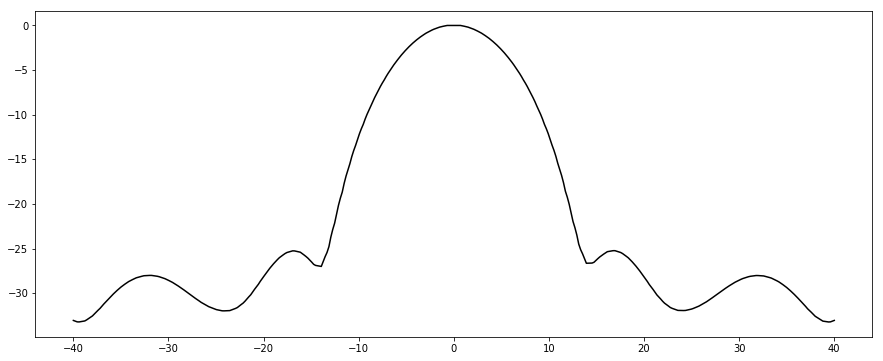

In [294]:

ang, beam = beam_cut(hera_im[:,100], ang_from_center=40, n=400)

plt.figure(figsize=(15,6))
plt.plot(ang-90,10*np.log10(beam), 'k', label='Modeled Beam')

fwhm = []

idx = np.argmin(np.abs(beam - np.max(beam) / 2.0))
print np.abs(ang[idx] - 90)


fwhm.append(2*np.abs(ang[idx] - 90))

for j in np.arange(1,4):
    scale = np.zeros_like(hera_im[:,100])
    s = j*0.01
    for i in np.arange(int(hera_im[:,100].shape[0]/ 2.0)):
        theta, phi = hp.pix2ang(nside, i)
        if np.abs(theta) < s:
            s = 0
        if np.abs(phi) < s:
            s = 0
        scale[i] = hp.get_interp_val(hera_im[:,100], theta-s,  phi-s)
    ang, beam_scale = beam_cut(scale, ang_from_center=40, n=400)
    idx = np.argmin(np.abs(beam_scale - np.max(beam_scale) / 2.0))
    fwhm.append(2*np.abs(ang[idx] - 90))
    plt.plot(ang-90, 10*np.log10(beam_scale), linestyle='--')
    
plt.legend()
plt.grid()
plt.show()

5.313283208020053


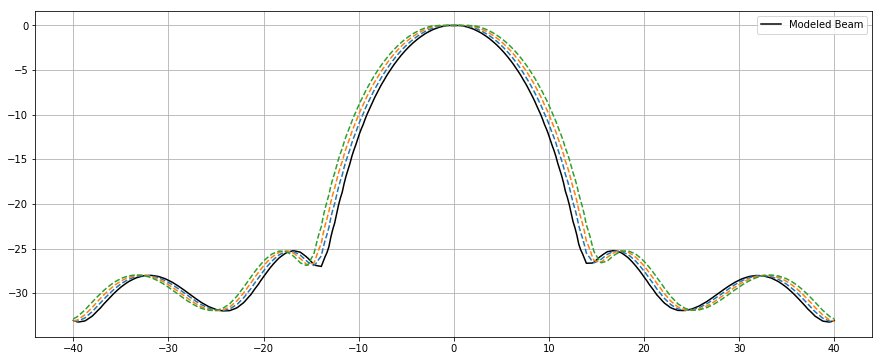

In [52]:

ang, beam = beam_cut(hera_im[:,100], ang_from_center=40, n=400)

plt.figure(figsize=(15,6))
plt.plot(ang-90,10*np.log10(beam), 'k', label='Modeled Beam')

fwhm = []

idx = np.argmin(np.abs(beam - np.max(beam) / 2.0))
print np.abs(ang[idx] - 90)


fwhm.append(2*np.abs(ang[idx] - 90))

for j in np.arange(1,4):
    scale = np.zeros_like(hera_im[:,100])
    s = j*0.015
    for i in np.arange(int(hera_im[:,100].shape[0]/ 2.0)):
        theta, phi = hp.pix2ang(nside, i)
        scale[i] = hp.get_interp_val(hera_im[:,100], theta - s / 2.0,  phi - s)
    ang, beam_scale = beam_cut(scale, ang_from_center=40, n=400)
    idx = np.argmin(np.abs(beam_scale - np.max(beam_scale) / 2.0))
    fwhm.append(2*np.abs(ang[idx] - 90))
    plt.plot(ang-90, 10*np.log10(beam_scale), linestyle='--')
    
plt.legend()
plt.grid()
plt.show()

In [53]:
np.abs(fwhm[0]-np.array(fwhm))/fwhm[0]

array([0.        , 0.0754717 , 0.1509434 , 0.22641509])

# Scaling the sidelobes

In [267]:
ang, beam_scale = beam_cut(scale, ang_from_center=90, n=400)
ang, beam = beam_cut(hera_im[:,100], ang_from_center=90, n=400)

idx_1 = np.argmin(np.abs((ang-90) - np.abs(ang[np.r_[True, beam[1:] < beam[:-1]] & 
                                               np.r_[beam[:-1] < beam[1:], True]]-90).min()))
idx_2 = np.argmin(np.abs((ang-90) + np.abs(ang[np.r_[True, beam[1:] < beam[:-1]] & 
                                               np.r_[beam[:-1] < beam[1:], True]]-90).min()))


new_beam = np.copy(beam)
#new_beam[idx_1+1:] *= 1.5
#new_beam[:idx_2] *= 1.5


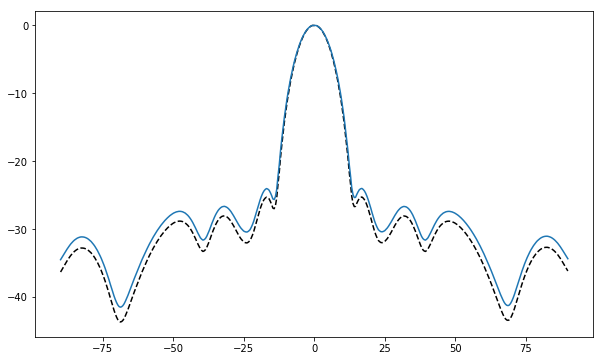

In [274]:
plt.figure(figsize=(10,6))
plt.plot(ang-90,10*np.log10(beam), 'k--')
plt.plot(ang-90,10*np.log10(new_beam**0.95))
plt.show()

(0, 0.005)

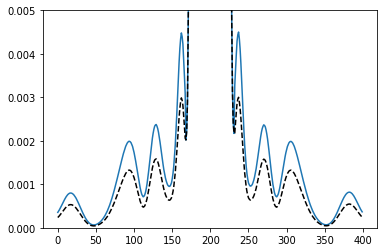

In [219]:
plt.plot(new_beam)
plt.plot(beam, 'k--')
plt.ylim([0,0.005])

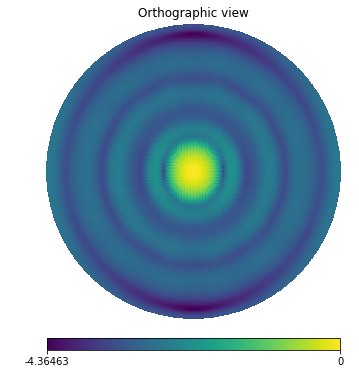

In [56]:
hp.orthview(np.log10(hera_im[:,100]), rot=[0,90], half_sky=True)